In [1]:
import requests
import pandas as pd

def obtencion_datos():
    # Endpoint para Financial Summaries (déficit/superávit fiscal)
    url_financial_summaries = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service//v1/accounting/mts/mts_table_1"

    # Parámteros para filtrar por fecha reciente (por ejemplo, datos de 2023)
    params = {
        'filter': 'record_date:gte:2017-01-01',  # 'gte' significa "greater than or equal"
        'sort': '-record_date',  # Ordenar los resultados por fecha descendente (más recientes primero)
        'page[size]': 10000  # Limitar el número de resultados
    }

    # Hacemos la solicitud a la API
    financial_data = requests.get(url_financial_summaries, params=params).json()

    financial_df = pd.DataFrame(financial_data['data'])

    # Convertir las columnas de interés a numérico
    financial_df['current_month_gross_rcpt_amt'] = pd.to_numeric(financial_df['current_month_gross_rcpt_amt'], errors='coerce')
    financial_df['current_month_gross_outly_amt'] = pd.to_numeric(financial_df['current_month_gross_outly_amt'], errors='coerce')

    # Convertir 'record_date' a formato de fecha
    financial_df['record_date'] = pd.to_datetime(financial_df['record_date'])

    # Intentamos convertir 'print_order_nbr' a numérico
    financial_df['print_order_nbr'] = pd.to_numeric(financial_df['print_order_nbr'], errors='coerce')

    # MODIFICACION DEL DATASET PARA OBTENER POR CADA COMBINACION DE MES Y ANIO UN UNICO VALOR

    # Creamos columnas de año y mes
    financial_df['year'] = financial_df['record_date'].dt.year
    financial_df['month'] = financial_df['record_date'].dt.month

    # Función para obtener la fila con el segundo valor más alto de 'print_order_nbr'
    def second_highest(group):
        return group.nlargest(2, 'print_order_nbr').iloc[-1]

    # Agrupamos por año y mes, y aplicamos la función
    result = financial_df.groupby(['year', 'month']).apply(second_highest).reset_index(drop=True)

    # Ordenamos el resultado por fecha (más reciente primero)
    Recaudacion_year_month = result.sort_values(['year', 'month'], ascending=False)

    # Mostramos el resultado
    return(Recaudacion_year_month)





**VISUALIZACION DEL GASTO E INGRESOS**

C:\Users\yeyer\AppData\Local\Temp\ipykernel_48580\1371639861.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = financial_df.groupby(['year', 'month']).apply(second_highest).reset_index(drop=True)


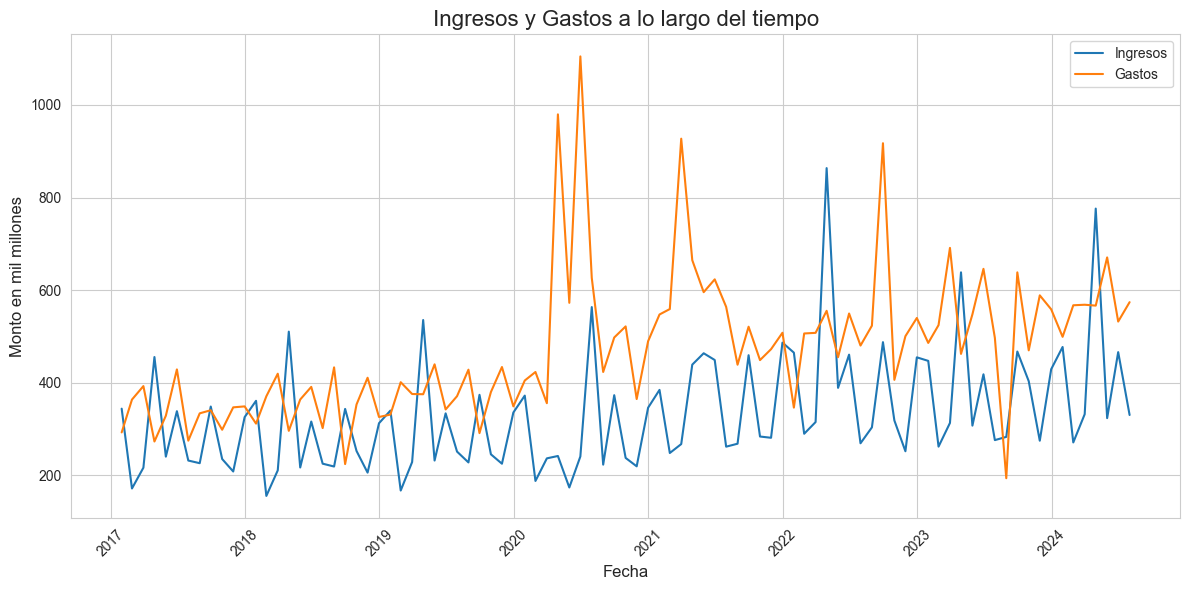

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asumimos que ya tienes un DataFrame llamado 'df' con las columnas necesarias


# Ordenamos el DataFrame por fecha
Recaudacion_year_month = obtencion_datos()
df = Recaudacion_year_month.sort_values('record_date')
# Convertir los valores a millones
df['current_month_gross_rcpt_amt'] = Recaudacion_year_month['current_month_gross_rcpt_amt'] / 1000000000
df['current_month_gross_outly_amt'] = Recaudacion_year_month['current_month_gross_outly_amt'] / 1000000000


# Creamos el gráfico
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Graficamos los ingresos
sns.lineplot(x='record_date', y='current_month_gross_rcpt_amt', data=df, label='Ingresos')

# Graficamos los gastos
sns.lineplot(x='record_date', y='current_month_gross_outly_amt', data=df, label='Gastos')

# Configuramos el título y las etiquetas
plt.title('Ingresos y Gastos a lo largo del tiempo', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Monto en mil millones', fontsize=12)

# Rotamos las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Ajustamos el diseño
plt.tight_layout()

# Mostramos el gráfico
plt.show()

**BOT DE TELEGRAM PARA ENVIAR MENSAJE**

In [77]:
from datetime import datetime
import time

# Definir el PIB del 2023
pib_2023 = 27.36e12  # 27.36 billones en notación científica

# Función para calcular el gasto acumulado desde enero de 2024
def calcular_gasto_acumulado(df_gastos):
    fecha_actual = datetime.now()
    anio_actual = fecha_actual.year
    mes_actual = fecha_actual.month

    # Filtrar datos desde enero de 2024 hasta la fecha actual
    df_gastos['record_date'] = pd.to_datetime(df_gastos['record_date'])
    df_gastos = df_gastos[(df_gastos['record_date'].dt.year == anio_actual) & (df_gastos['record_date'].dt.month <= mes_actual)]
    gasto_acumulado = df_gastos['current_month_gross_outly_amt'].sum()
    return gasto_acumulado

# Función para verificar si el gasto está cercano al PIB y enviar notificación
def verificar_y_notificar(gasto_acumulado):
    porcentaje_umbral = 0.10 # 38% del PIB 
    if gasto_acumulado >= porcentaje_umbral * pib_2023:
        enviar_notificacion(gasto_acumulado,porcentaje_umbral)
        #return print("el gasto esta superando el {porcentaje_umbral}")

#Función para enviar una notificación (ejemplo con Telegram)
def enviar_notificacion(gasto_acumulado,porcentaje_umbral):
    token = "7505196905:AAFrQhr9A3R4aqfDMhuGSzQWM7dVbP7ZXmo"  # Reemplaza con tu token de Telegram
    chat_id = "1732985833"  # Reemplaza con tu chat ID de Telegram
    mensaje = f"Alerta: El gasto acumulado de {gasto_acumulado:,.2f} USD está cerca del {porcentaje_umbral}% del PIB de 2023."
    url = f"https://api.telegram.org/bot{token}/sendMessage?chat_id={chat_id}&text={mensaje}"
    requests.get(url)

def main():
    while True:
        gasto_acumulado = calcular_gasto_acumulado(Recaudacion_year_month)
        verificar_y_notificar(gasto_acumulado)
        time.sleep(10)  # Esperar 10 segundos antes de la siguiente iteración

if __name__ == "__main__":
    main()

KeyboardInterrupt: 